In [1]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Inspiration for code:

- https://developers.google.com/machine-learning/guides/text-classification/
- https://github.com/google/eng-edu/blob/master/ml/guides/text_classification/load_data.py

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random
import time
import pickle
import gc

import numpy as np
import pandas as pd

from importlib import reload

import scipy.sparse

In [3]:
from helpers import load_data
from helpers import explore_data
from helpers import preprocess_data
from helpers import train_model

## Load the data

In [4]:
pwd

'/tf/notebooks/final-project/Classification'

In [5]:
!head -2 /tf/notebooks/final-project/data/sample/hein-daily/speeches_097.txt

speech_id|speech
970000001|The Senate vill please come to order. The Chaplain will offer the prayer. The Chaplain. the Reverend Edward L. R. Elson. D.D.. offered the following prayer: PRAYER God of our fathers and our God. who has made and preserved us a nation. we thank Thee for Thy care over us from generation to generation. and for the new era which unfolds before us. Let Thy spirit descend upon us with all Its cleansing. healing. and creative power. Make usnew persons for new times in a land newborn in spirit. May the solemn induction of the new Members of this body be a renewal of the vocatinal vows of all others. In the deliberations of this new Congress keep our motives pure. our vision clear. our patriotism undefiled. our speech chaste. our judgments fair. and our consciences unbetrayed. Help us to develop work patterns which sustain the soul. nourish the mind. and strengthen the will. And give us grace to make time for the family. for home. and for worship. What we pray for th

In [6]:
!cat /tf/notebooks/final-project/data/sample/hein-daily/speeches_097.txt | wc -l

283399


In [4]:
data_path = '/tf/notebooks/final-project/data/sample/hein-daily'

In [5]:
reload(load_data)
all_speech_ids, all_speeches = load_data.load_speech_data(data_path)


File speeches_097.txt has 249718612 characters
and 283399 speeches

Speeches list has 283399 speeches


In [6]:
len(all_speech_ids), len(all_speeches)

(283399, 283399)

## Create target labels

In [2]:
!cat /tf/notebooks/final-project/data/QA/full_descr.txt | wc -l

2914465


In [ ]:
# OPEN descr FROM A SAVED FILE (if it was previously saved)
outdata_path = '/home/yulia/final-project/Classification/data'
descr = pickle.load(open(os.path.join(outdata_path, 'descr.p'), 'rb'))

37,617 fuzzy match speeches had multiple duplicates. Delete them from the dictionary

In [6]:
reload(load_data)
start_time = time.time()
descr = load_data.load_descr_data('/tf/notebooks/final-project/data/QA/full_descr.txt')
print("\nIt took {0:.1f} seconds to create the dictionary".format(time.time()-start_time))

2914465 lines have been read
37617 keys had duplicates and deleted
The dictionary has 2808050 keys

Random congressperson: 1030122595
check 1
NonWhite 0.0
speaker Mr. MORAN
Congress 103
char_count 5016
Age 49.0
State VA
Female 0.0
Party D
Full Name MORAN, JAMES
speakerid 103117750.0
word_count 851
Age_lt_med 1.0
match exact
Ethnicity W
date 19931120
Chamber H

It took 15.7 seconds to create the dictionary


In [7]:
# check if sampling worked
len(list(descr.keys()))/2914464

0.9634876258550458

In [8]:
gender, ethnicity, age, party, chamber, congress = load_data.create_target_labels(all_speech_ids, descr)
len(gender), len(ethnicity), len(age), len(party), len(chamber), len(congress)

(283399, 283399, 283399, 283399, 283399, 283399)

### Save descr dictionary

In [15]:
pwd

'/tf/notebooks/final-project/Classification'

In [233]:
outdata_path = '/tf/notebooks/final-project/Classification/data'

In [234]:
pickle.dump(descr, open(os.path.join(outdata_path, 'descr.p'), 'wb'))

MemoryError: 

In [ ]:
descr = pickle.load(open(os.path.join(outdata_path, 'descr.p'), 'rb'))

### Data QA

In [9]:
reload(explore_data)
for i in [(gender, "Gender"), (ethnicity, "Ethnicity"), (age, "Age")]:
    print("\n", i[1])
    print("Overall speech counts:")
    explore_data.get_counts(i[0])
    print("Target group number of speeches by party:")
    explore_data.get_counts_by_category(i[0], party)


 Gender
Overall speech counts:


,Category,Count
0,-1,64727
1,0,214221
2,1,4451


Target group number of speeches by party:
D: 	 2172
I: 	 0
N: 	 0
NA: 	 -64727
R: 	 2279

 Ethnicity
Overall speech counts:


,Category,Count
0,-1,64727
1,0,209473
2,1,9199


Target group number of speeches by party:
D: 	 7832
I: 	 0
N: 	 186
NA: 	 -64727
R: 	 1181

 Age
Overall speech counts:


,Category,Count
0,-1,64727
1,0,142904
2,1,75768


Target group number of speeches by party:
D: 	 40729
I: 	 0
N: 	 186
NA: 	 -64727
R: 	 34853


## Split into train, validate, test

In [206]:
reload(preprocess_data)
train, train_ids, train_target, val, val_ids, val_target, test, test_ids, test_target = preprocess_data.split_train_val_test(all_speeches, all_speech_ids, gender, descr)

Training split: 1622 ones and 1622 zeroes
Training speech list size: 3244
Training target list size: 3244
Validation split: 540 ones and 540 zeroes
Validation speech list size: 1080
Validation target list size: 1080
Test split: 542 ones and 542 zeroes
Test speech list size: 1084
Test target list size: 1084


In [194]:
sum(train_target), sum(val_target), sum(test_target)

(1622, 540, 542)

In [195]:
# number of speeches under 30 words
sum(np.array(gender)==1) - (sum(train_target) + sum(val_target) + sum(test_target))

1747

## CNN

Inspiration for code: https://developers.google.com/machine-learning/guides/text-classification/step-3

### Pre-processing

In [13]:
reload(explore_data)
explore_data.get_num_words_per_sample(train)

204.0

Speech length percentiles
    0     10    20     30     40     50     60     70     80     90      100
0  31.0  45.0  67.0  102.0  149.0  203.5  268.0  353.0  499.0  738.7  8435.0


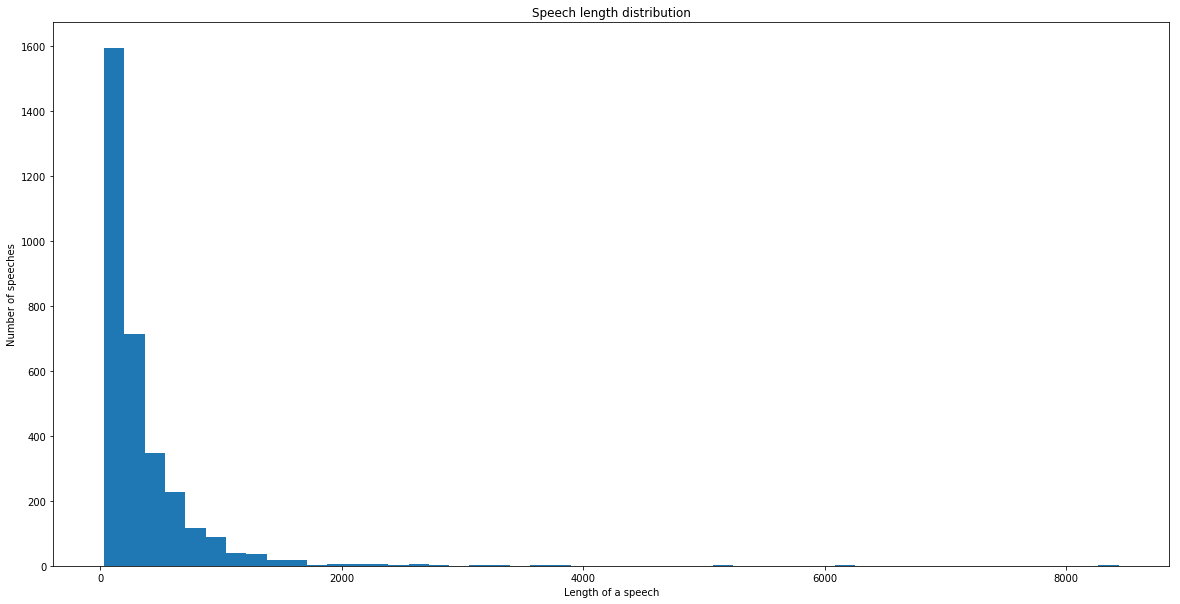

In [157]:
reload(explore_data)
explore_data.plot_sample_length_distribution(train)

In [59]:
# import nltk
# nltk.download('punkt')
# sent_text = nltk.sent_tokenize(train[0])
# for sentence in sent_text:
#     tokenized_text = nltk.word_tokenize(sentence)
#     print(tokenized_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [207]:
reload(preprocess_data)
train_chunk, train_ids_chunk, train_target_chunk = preprocess_data.split_speech_to_chunks(train, train_ids, train_target, max_len=100)

Original data has 3244 speeches
It was split into 12496 chunks
Checks on ids and target 12496 12496
Original target mean 0.5
New target mean 0.5060819462227913


In [197]:
val_chunk, val_ids_chunk, val_target_chunk = preprocess_data.split_speech_to_chunks(val, val_ids, val_target, max_len=100)

Original data has 1080 speeches
It was split into 4252 chunks
Checks on ids and target 4252 4252
Original target mean 0.5
New target mean 0.47765757290686733


In [198]:
test_chunk, test_ids_chunk, test_target_chunk = preprocess_data.split_speech_to_chunks(test, test_ids, test_target, max_len=100)

Original data has 1084 speeches
It was split into 4189 chunks
Checks on ids and target 4189 4189
Original target mean 0.5
New target mean 0.5301981379804249


In [268]:
# Limit on the number of features. 
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
# MAX_SEQUENCE_LENGTH = 100
MAX_SEQUENCE_LENGTH = 750

vec_params = {
    'num_words': TOP_K,
    'max_seq_length': MAX_SEQUENCE_LENGTH
}

In [269]:
reload(preprocess_data)
train_vec, val_vec, test_vec, word_index = preprocess_data.sequence_vectorize(train, val, test, **vec_params)

In [200]:
len(train), len(val), len(test)

(3244, 1080, 1084)

In [164]:
#len(train_chunk), len(val_chunk), len(test_chunk)

(12370, 4010, 4089)

In [267]:
len(train_vec), len(val_vec), len(test_vec)

(3244, 1080, 1084)

In [277]:
train_vec[0].shape

(750,)

In [278]:
train_vec[0][-10:]

array([  52, 3587,   52,  906,   63,   14,    5,   14,    9,   48],
      dtype=int32)

In [279]:
train[0]

'Mr. Speaker. I want to compliment the gentleman from California for his comments. I think one of the things that he and the gentleman from Wisconsin were pointing out is that they had some perfecting punendments to the Commission that would have made it better. I think some of the things that people worried about were the calendar days rather than legislative days. the November 15 date. the two Houses having to turn it down. and so forth. That really did make it look a little suspicious. I understand the gentleman being angry about people portraying it as an automatic pay increase. but I think when it was put in both reconciliation and the supplemental with those kinds of things it did come across that way. and it is really too bad. The gentleman is correct. This must be argued openly. It must be argued out front. It must be dealt with by this body. There is no way to find some magic pay fairy who is going to say. "Here. take it. you have to have it. even if you do not want it." I thi

In [280]:
train_chunk[0]

'Mr. Speaker. I want to compliment the gentleman from California for his comments. I think one of the things that he and the gentleman from Wisconsin were pointing out is that they had some perfecting punendments to the Commission that would have made it better. I think some of the things that people worried about were the calendar days rather than legislative days. the November 15 date. the two Houses having to turn it down. and so forth. That really did make it look a little suspicious. I understand the gentleman being angry about people portraying it as an automatic'

In [281]:
word_index['is'], word_index['there']

(9, 48)

In [283]:
len(word_index)

40496

## CNN Models

In [21]:
logs_base_dir = "/tf/notebooks/final-project/Classification/logs"

In [ ]:
sepcnn_model_params = {
    'model': 'cnn',
    'blocks': 2,
    'learning_rate': 0.01,
    'epochs': 1000,
    'batch_size': 128,
    'filters': 64,
    'dropout_rate': 0.2,
    'embedding_dim': 100,
    'kernel_size': 3,
    'pool_size': 1,
    'max_num_words': TOP_K,
    'use_pretrained_embedding': True,
    'is_embedding_trainable': True,
    'glove_dir': '/tf/notebooks/final-project/data'
}

In [271]:
cnn_model_params = {
    'model': 'cnn',
    'learning_rate': 0.001,
    'layers': 2,
    'epochs': 1000,
    'batch_size': 128,
    'filters': 64,
    'dropout_rate': 0.2,
    'embedding_dim': 100,
    'kernel_size': 3,
    'pool_size': 1,
    'max_num_words': TOP_K,
    'use_pretrained_embedding': True,
    'is_embedding_trainable': True,
    'glove_dir': '/tf/notebooks/final-project/data'
}

In [179]:
# train_shuffle = np.random.permutation(np.arange(len(train_target_chunk)))
# train_vec = train_vec[train_shuffle]
# train_target_chunk = np.array(train_target_chunk, dtype=int)[train_shuffle]

In [257]:
len(train_target_chunk), len(train_target)

(12496, 3244)

In [272]:
reload(train_model)
history, train_pred_probs, val_pred_probs = train_model.train_model(((train_vec, train_target), (val_vec, val_target)), word_index, logs_base_dir, **cnn_model_params)

Found 400000 word vectors.
It took 9.2 seconds
Preparing embedding matrix.
Embedding matrix has been built.
Its shape is (20000, 100).
It took 0.0 seconds
Train on 3244 samples, validate on 1080 samples
Epoch 1/1000
 - 8s - loss: 0.8881 - acc: 0.4892 - val_loss: 0.6880 - val_acc: 0.5500
Epoch 2/1000
 - 8s - loss: 0.7199 - acc: 0.4972 - val_loss: 0.6762 - val_acc: 0.6065
Epoch 3/1000
 - 8s - loss: 0.6958 - acc: 0.5413 - val_loss: 0.6560 - val_acc: 0.6528
Epoch 4/1000
 - 8s - loss: 0.6664 - acc: 0.5835 - val_loss: 0.6279 - val_acc: 0.6630
Epoch 5/1000
 - 8s - loss: 0.6467 - acc: 0.6097 - val_loss: 0.6089 - val_acc: 0.6676
Epoch 6/1000
 - 8s - loss: 0.6230 - acc: 0.6483 - val_loss: 0.6026 - val_acc: 0.6676
Epoch 7/1000
 - 8s - loss: 0.6194 - acc: 0.6544 - val_loss: 0.5974 - val_acc: 0.6694
Epoch 8/1000
 - 8s - loss: 0.6172 - acc: 0.6520 - val_loss: 0.5926 - val_acc: 0.6731
Epoch 9/1000
 - 8s - loss: 0.6081 - acc: 0.6751 - val_loss: 0.5926 - val_acc: 0.6741
Epoch 10/1000
 - 8s - loss: 0.60

## Model evaluation

In [273]:
val_preds.shape, len(val_target)

((4252, 1), 1080)

In [274]:
val_preds = val_pred_probs > 0.5
np.sum(val_preds.flatten()==val_target)

746

Confusion matrix, without normalization
[[297 243]
 [ 91 449]]


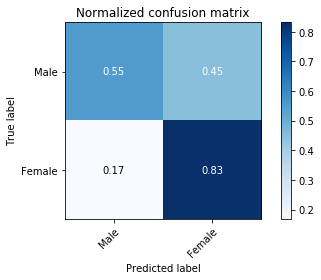

In [276]:
reload(explore_data)
# specify class names in 0 - 1 order
classes = ['Male', 'Female']
explore_data.plot_confusion_matrix(val_target, val_preds, classes, normalize=True)

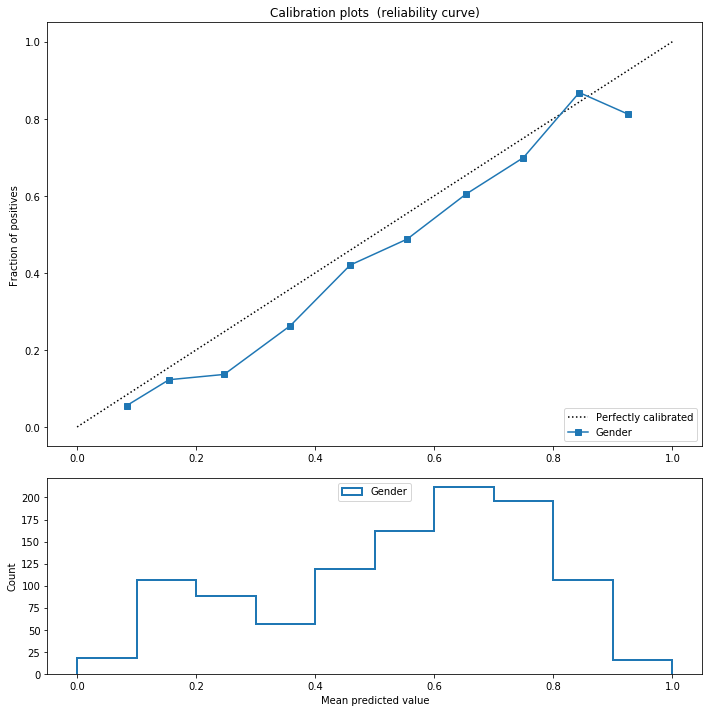

In [284]:
reload(explore_data)
explore_data.plot_calibration_curve(val_target, val_pred_probs, 'Gender')

In [285]:
val_random = np.random.choice(a=[0,1], size=len(val_target), p = [0.7,0.3])
val_random.sum()/val_random.shape[0]

0.27037037037037037

In [286]:
val_sample, val_ids_sample, val_pred_probs_sample = [], [], []
for i in range(len(val_ids)):
    if val_random[i] == 1:
        val_sample.append(val[i])
        val_ids_sample.append(val_ids[i])
        val_pred_probs_sample.append(val_pred_probs[i])
len(val_sample), len(val_ids_sample), len(val_pred_probs_sample)

(292, 292, 292)

In [287]:
reload(explore_data)
explore_data.check_bin_probs_distr(val_pred_probs_sample, val_ids_sample, descr)

Finished building main df


,Gender_F,Ethinicity_NW,AvgAge,Party_D,Chamber_H,AvgWordCount
0.4,0.28,0.30,1.03,0.80,0.18,1.22
0.6,0.95,0.61,1.01,0.94,1.14,0.76
1.0,1.45,1.62,0.98,1.15,1.40,1.01


In [288]:
reload(explore_data)
explore_data.compare_ngrams(val, val_pred_probs)


Top 10 ngrams by differentiating score:
the senator from 	 58.2
unanimous consent that 	 51.8
mr president ask 	 49.0
ask unanimous consent 	 48.4
ask unanimous consent that 	 48.4
president ask unanimous consent 	 41.3
president ask unanimous 	 40.6
mr president ask unanimous 	 35.3
in the record 	 31.2
be printed in 	 29.9


,0.4,0.6,1.0
ask unanimous consent,49.0,14.0,3.0
ask unanimous consent that,42.0,10.0,0.0
be printed in,31.0,6.0,3.0
in the record,49.0,13.0,15.0
mr president ask,37.0,4.0,2.0
mr president ask unanimous,27.0,3.0,1.0
president ask unanimous,30.0,3.0,1.0
president ask unanimous consent,29.0,3.0,0.0
the senator from,124.0,14.0,0.0
unanimous consent that,44.0,10.0,0.0


In [289]:
reload(explore_data)
explore_data.ngrams_by_bin(val_sample, val_pred_probs_sample)


In 0.4 bin top 10 ngrams:

the united states
the senator from
the federal reserve
high interest rates
there is no
one of the
of the senate
federal reserve board
the federal reserve board
in the record
--------------------

In 0.6 bin top 10 ngrams:

the united states
the federal government
are going to
the american people
would like to
house of representatives
one of the
members of the
chairman of the
the gentleman from
--------------------

In 1.0 bin top 10 ngrams:

the soviet union
the united states
the gentleman from
would like to
in support of
the federal government
the fact that
one of the
the american people
support of the
--------------------


In [290]:
reload(explore_data)
explore_data.print_mispredictions(val_target, val_pred_probs, val, val_ids, descr)


True positive (Predicted prob: 0.92):

check 1
NonWhite 0.0
speaker Ms. FERRARO
Congress 97
char_count 1364
Age 47.0
State NY
Female 1.0
Party D
Full Name FERRARO, GERALDINE
speakerid 97106680.0
word_count 221
Age_lt_med 1.0
match fuzzy
Ethnicity W
date 19821215
Chamber H

 Mr. Chairman. I rise in support of the amendment to lessen the adverse effects of the pension offset provision. Utider this provision which has just become effective. dependents benefits under social security are reduced dollar for dollar for any public pension received as a result of Government employment. We must E 5216 act today to delay it or 5.000 women will lose a significant portion of their social security spousal benefits. Had I been in Congress when this provision was considered. I would have opposed it on principle as well as practice. In principle. it is wrong to compare social security entitlements with pensions earned as a result of a career. in public service. However. in practice. this offset is eve